In [1]:
import pandas as pd
import numpy as np

import re

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import yaml

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import spacy

from multiprocessing import Pool, cpu_count
 

RAND = 42

In [2]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(8, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [3]:
def barplot_group(df: pd.DataFrame, col_main: str, col_group: str, title: str = None) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [4]:
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # фильтрация выбросов
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    return df[(df[col] > lower_bound) & (df[col] < upper_bound)]

In [5]:
def change_id(df_t: pd.DataFrame, columns: list) -> None:
    for col in columns:
        df_t[col] = df_t[col].apply(lambda x: x.split('_')[1])

In [6]:
config_path = "../config/params.yaml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config["preprocessing"]

# Описание задачи

Данные предоставлены оператором электронных торгов.  

Задача состоит в разработке **рекомендательного сервиса** для поставщиков.  

В данном случае рекомендательный сервис необходим для более активного участия поставщиков в торгах за счет того, что им предлагаются более подходящие для них заказы.  

Для разработки рекомендательного алгоритма имеется информация о предыдущих заказах и участии поставщиков в них. Также известно, какой из поставщиков победил в торгах.  

Поля в датасете purchases:  
 - purchase – Уникальный идентификатор закупки  
 - region_code – Регион поставки  
 - min_publish_date – Дата публикации закупки (дата, с которой закупку смогли видеть поставщики и присылать свои предложения)  
 - purchase_name – Название закупки  
 - forsmallbiz – Если да, то большие компании не могут предлагать свое участие в этой закупке  
 - price – Цена за закупку, предлагаемая заказчиком  
 - customer – Уникальный идентификатор заказчика  
 - okpd2_code – Код стандартизации товара в соответствии со справочником ОКПД2, обрезанный до 3 числа  
 - okpd2_names – Названия ОКПД2, в этом поле может быть записано несколько названий ОКПД2 через разделитель “ || “, так как поле okpd2_code это обобщенный код.
 - Item_descriptions – Описания товаров, записанные через разделитель “ || “.  
 
Поля в датасете suppliers:  
 - purchase – Уникальный идентификатор закупки  
 - supplier – Уникальный идентификатор поставщика  
 - is_winner – Выиграл ли этот поставщик в этой закупке

In [7]:
df_pur = pd.read_csv("../data/small_purchases.csv", sep=";")
df_sup = pd.read_csv("../data/small_suppliers.csv", sep=";")

In [8]:
df_pur[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions
0,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.00,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита
1,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.00,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита
2,Закупка_3,2,2021-02-02,оказание информационных услуг с использованием...,t,290000.00,Заказчик_2,58.2,Услуги по предоставлению лицензий на право исп...,оказание информационных услуг с использованием...
3,Закупка_4,2,2021-02-02,"Услуги по дизайнерскому оформлению, изготовлен...",t,190809.00,Заказчик_2,18.1,"Услуги печатные прочие, не включенные в другие...","оказание услуг по дизайнерскому оформлению, из..."
4,Закупка_5,2,2021-02-11,поставка сувенирной продукции для проведения м...,t,278263.34,Заказчик_2,26.2,Клавиатуры || Комплектующие и запасные части д...,Комплект беспроводной клавиатуры и беспроводно...


In [9]:
df_sup[:5]

,purchase,supplier,is_winner
0,Закупка_3,Поставщик_1,1
1,Закупка_14,Поставщик_2,1
2,Закупка_14,Поставщик_3,0
3,Закупка_5,Поставщик_4,0
4,Закупка_5,Поставщик_2,0


In [10]:
df = pd.merge(df_pur, df_sup, on='purchase')
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner
0,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104753,1
1,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104929,0
2,Закупка_1,2,2021-11-24,Услуги по проведению финансового аудита,f,190000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_37544,0
3,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_104753,1
4,Закупка_2,2,2022-11-18,Услуги по проведению финансового аудита,f,271000.0,Заказчик_1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,Поставщик_11259,0


In [11]:
change_id(df, ["purchase", "customer", "supplier"])
df['forsmallbiz'].replace({'t': 1, 'f': 0}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958129 entries, 0 to 958128
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   purchase           958129 non-null  object 
 1   region_code        958129 non-null  int64  
 2   min_publish_date   958129 non-null  object 
 3   purchase_name      958044 non-null  object 
 4   forsmallbiz        958129 non-null  int64  
 5   price              958129 non-null  float64
 6   customer           958129 non-null  object 
 7   okpd2_code         958129 non-null  object 
 8   okpd2_names        958129 non-null  object 
 9   item_descriptions  957564 non-null  object 
 10  supplier           958129 non-null  object 
 11  is_winner          958129 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 95.0+ MB


In [13]:
df.shape

(958129, 12)

In [14]:
df = df.astype(preproc['change_type_columns'])

In [15]:
df.describe().iloc[1:, :]

,forsmallbiz,price,is_winner
mean,0.709252,5.400899e+06,0.346879
std,0.454108,1.448377e+08,0.475977
min,0.000000,1.700000e-01,0.000000
25%,0.000000,1.661750e+05,0.000000
50%,1.000000,5.992800e+05,0.000000
75%,1.000000,2.038950e+06,1.000000
max,1.000000,5.703527e+10,1.000000


In [16]:
df.describe(include=object)

,purchase_name,item_descriptions
count,958044,957564
unique,236046,138985
top,Поставка канцелярских товаров,Бумага для офисной техники белая
freq,5239,10213


In [17]:
df.describe(include='category')

,purchase,region_code,customer,okpd2_code,okpd2_names,supplier
count,958129,958129,958129,958129,958129,958129
unique,328257,86,11680,244,21493,100732
top,424615,77,9582,drug,Лекарства,694
freq,80,309840,17809,99192,99192,4217


In [18]:
df.isna().sum()/df.shape[0] * 100

purchase             0.000000
region_code          0.000000
min_publish_date     0.000000
purchase_name        0.008871
forsmallbiz          0.000000
price                0.000000
customer             0.000000
okpd2_code           0.000000
okpd2_names          0.000000
item_descriptions    0.058969
supplier             0.000000
is_winner            0.000000
dtype: float64

In [19]:
df[df['item_descriptions'].isna()].describe(include=['category', object])

,purchase,region_code,purchase_name,customer,okpd2_code,okpd2_names,item_descriptions,supplier
count,565,565,565,565,565,565,0,565
unique,226,17,203,54,1,1,0,200
top,531605,33,Поставка лекарственного препарата для медицинс...,7549,drug,Лекарства,NaN,694
freq,13,111,13,85,565,565,NaN,30


In [20]:
#заполним пропуски в поле item_descriptions значениями из колонки purchase_name
df['item_descriptions'].fillna(df['purchase_name'], inplace=True)

In [21]:
df[df['purchase_name'].isna()].describe(include=['category', object])

,purchase,region_code,purchase_name,customer,okpd2_code,okpd2_names,item_descriptions,supplier
count,85,85,0,85,85,85,85,85
unique,42,9,0,15,14,31,31,43
top,482224,5,NaN,390,31.0,Бензин автомобильный АИ-92 экологического клас...,Шкаф деревянный для документов,2424
freq,3,44,NaN,20,34,6,6,10


In [22]:
#заполним пропуски в поле purchase_name значениями из колонки okpd2_names
df['purchase_name'].fillna(df['okpd2_names'], inplace=True)

In [23]:
df.isna().sum()

purchase             0
region_code          0
min_publish_date     0
purchase_name        0
forsmallbiz          0
price                0
customer             0
okpd2_code           0
okpd2_names          0
item_descriptions    0
supplier             0
is_winner            0
dtype: int64

In [24]:
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner
0,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104753,1
1,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104929,0
2,1,2,2021-11-24,Услуги по проведению финансового аудита,0,190000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,37544,0
3,2,2,2022-11-18,Услуги по проведению финансового аудита,0,271000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,104753,1
4,2,2,2022-11-18,Услуги по проведению финансового аудита,0,271000.0,1,69.2,Услуги по проведению финансового аудита,Услуги по проведению финансового аудита,11259,0


In [25]:
df['reg_code_small'] = df['okpd2_code'].astype('str') + '_' \
                + df['region_code'].astype('str') + '_' \
                + df['forsmallbiz'].astype('str')

In [26]:
df = df.sort_values(['supplier', 'min_publish_date'])

In [27]:
df[:5]

,purchase,region_code,min_publish_date,purchase_name,forsmallbiz,price,customer,okpd2_code,okpd2_names,item_descriptions,supplier,is_winner,reg_code_small
8,3,2,2021-02-02,оказание информационных услуг с использованием...,1,290000.00,2,58.2,Услуги по предоставлению лицензий на право исп...,оказание информационных услуг с использованием...,1,1,58.2_2_1
8151,2834,2,2021-02-02,Оказание информационных услуг с использованием...,1,105000.00,218,62.0,Оригиналы программного обеспечения прочие,Оказание информационных услуг с использованием...,1,1,62.0_2_1
457484,154949,2,2021-02-16,Оказание услуг по сопровождению (обновлению) с...,1,98967.50,11235,63.9,Услуги информационные автоматизированные компь...,Информационные услуги с использованием экземпл...,1,1,63.9_2_1
437783,147950,2,2021-03-10,Оказание информационных услуг с использованием...,0,77460.03,11061,62.0,Услуги по технической поддержке в области инфо...,Оказание информационных услуг с использованием...,1,1,62.0_2_0
488119,165990,2,2021-03-26,Обновление с использованием экземпляров Систем...,0,138000.00,11558,62.0,Услуги по технической поддержке информационных...,услуги по обновлению с использованием экземпля...,1,1,62.0_2_0


**Выводы**  
- 

- Максимальное значение цены тендера равно 5703527000, а минимальное - 0.17. Можно предположить, что среди такого большого диапазона значений есть свои ценовые сегменты.  
- Предыдущий факт также может говорить о том, что в датасете есть явные выбросы.  
- Кол-во уникальных значений purchase_name значительно больше числа уникальных значений okpd2_names, из-за чего можно предложить, что поле purchase_name несет более конкретную информацию об объекте и от того более информативно.    
- Признак is_winner, содержащий информацию о результатах закупок для каждого поставщика в соответствующей закупке, может быть эффективно использован в рекомендательной системе, если при рекомендации вариантов для поставщиков будет учитываться то, с какой вероятностью они победят в выбранных торгах.  
- Признаки region_code, forsmallbiz и okpd2_code могут служить фильтром в рекомендательной системе для некоторых поставщиков, так как переход на другие категории даже по схожими объектам может стать проблематичным.
- Признак min_publish_date может быть полезен для определения самых релевантных рекомендаций для поставщиков, у которых большое количество участий в закупках.

# Гипотезы

- Среди поставщиков можно выделить ценовые сегменты  
- У поставщиков высокая специализация по okpd2  
- Поставщики с большим количеством участий в закупках чаще выигравают  
- Покупатели отдают предпочтение тем поставщикам, с которыми они уже работали   
- В закупках с большей ценой участвует больше поставщиков, из-за чего шансы победить в них для конкретного поставщика снижаются  
- Поставщики, у которые уже специализация категориям okpd2, чаще побеждают в закупках  
- В закупках, у которых нет ограничения на размер компании-участника, больше участников, из-за чего шансы победить в них для конкретного поставщика снижаются  
- Сезонность влияет на участие поставщиков в закупках, поэтому это нужно учитывать при рекомендациях  
- Сезонность влияет на количество закупок на рынке в целом, отчего изменяется степень участия поставщиков в них 
- Значительная часть категорий закупок в силу сезонности находится на рынке только определенные месяцы 

## Гипотеза 1  
Среди поставщиков можно выделить ценовые сегменты

In [30]:
#сформируем датасет со средней ценой закупки у поставщика и стандартным отклонением этой цены
df_1 = df.groupby('supplier')['price'].mean().to_frame(name='price_mean')
df_1['price_std'] = df.groupby('supplier')['price'].std()

In [32]:
df_1 = remove_outliers(df_price, 'price_mean')

In [33]:
df_1.shape

(100607, 2)

<Axes: xlabel='price_mean', ylabel='price_std'>

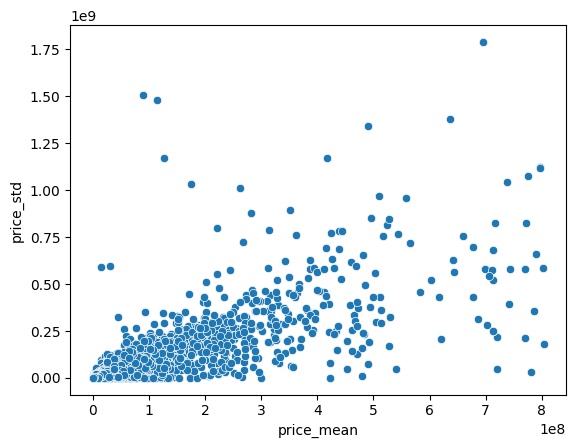

In [35]:
sns.scatterplot(x=df_1['price_mean'], y=df_1['price_std'])

Из графика данных, где по x -  средняя цена закупки, а по y - стандартное отклонение цен закупок поставщиков, показывает, что по только на основания данных признаков выделить кластеры поставщиков нельзя 

## Гипотеза 2

У поставщиков высокая специализация по okpd2

In [36]:
n_unique_okpd2 = df.groupby('supplier')['okpd2_code'].nunique()

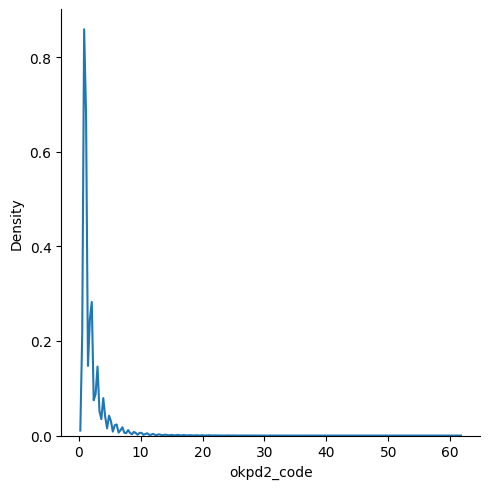

In [37]:
#распределение кол-ва уникальных okpd2 среди поставщиков
sns.displot(x=n_unique_okpd2, kind='kde')

Из графика видно, что количество уникальных значений okpd2 внутри большинства поставщиков ниже 10, что значительно меньше, чем количество категорий okpd2 всего. 

## Гипотеза 3

Поставщики с большим количеством участий в закупках чаще выигравают. 

In [40]:
df_3 = pd.DataFrame(df.groupby('supplier').size(), columns=['n_part'])
df_3['win_share'] = df[df.is_winner == 1].groupby('supplier').size() / df_3['n_part'] * 100

In [41]:
df_3[:5]

,n_part,win_share
supplier,,
1,21,100.000000
10,7,42.857143
100,6,66.666667
1000,3,0.000000
10000,10,30.000000


In [42]:
df_3 = remove_outliers(df_3, 'n_part')

In [43]:
df_3.shape

(99879, 2)

In [48]:
mov_avg = weighted_moving_average(df_3.groupby('n_part')['win_share'].mean(), 
                                  df_3.groupby('n_part').size(), n_window=10)

<Axes: ylabel='win_share'>

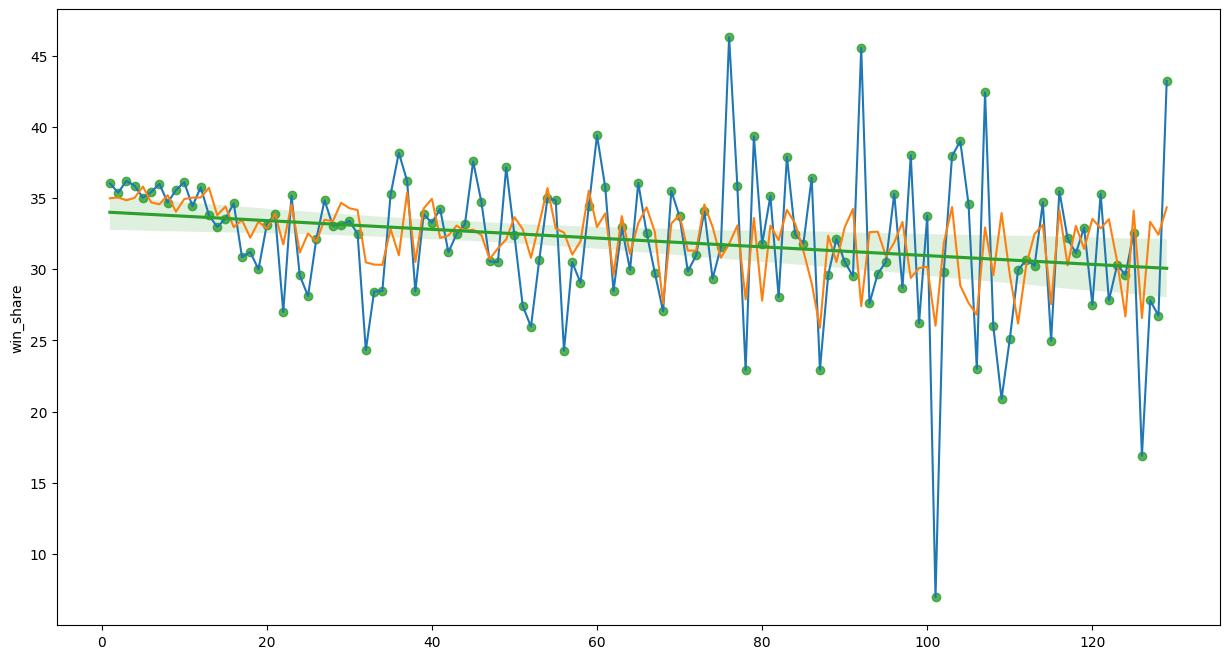

In [49]:
fig = plt.figure(figsize=[15,8])
sns.lineplot(x=df_3.n_part.unique(), 
             y=df_3.groupby('n_part')['win_share'].mean())
sns.lineplot(x=df_3.n_part.unique(), y=mov_avg, label='Скольз. среднее')
sns.regplot(x=df_3.n_part.unique(), 
            y=df_3.groupby('n_part')['win_share'].mean(), label='Лин. регрессия')

fig.legend()

Как видно по графику, наклон регрессионной прямой близок к нулю, что говорит о том, что гипотеза не подтвердилась.

## Гипотеза 4

Покупатели отдают предпочтение тем поставщикам, с которыми они уже работали

In [50]:
n_won = df.groupby(['supplier', 'customer'])['is_winner'].cumcount()
df_4 = df.join(n_won.rename('n_won'), how='outer')[['is_winner', 'n_won']]

df_4['flag_won'] = df_4['n_won'].apply(lambda x: 1 if x != 0 else 0)

In [51]:
df_4[:5]

,is_winner,n_won,flag_won
8,1,0,0
8151,1,0,0
457484,1,0,0
437783,1,0,0
488119,1,0,0


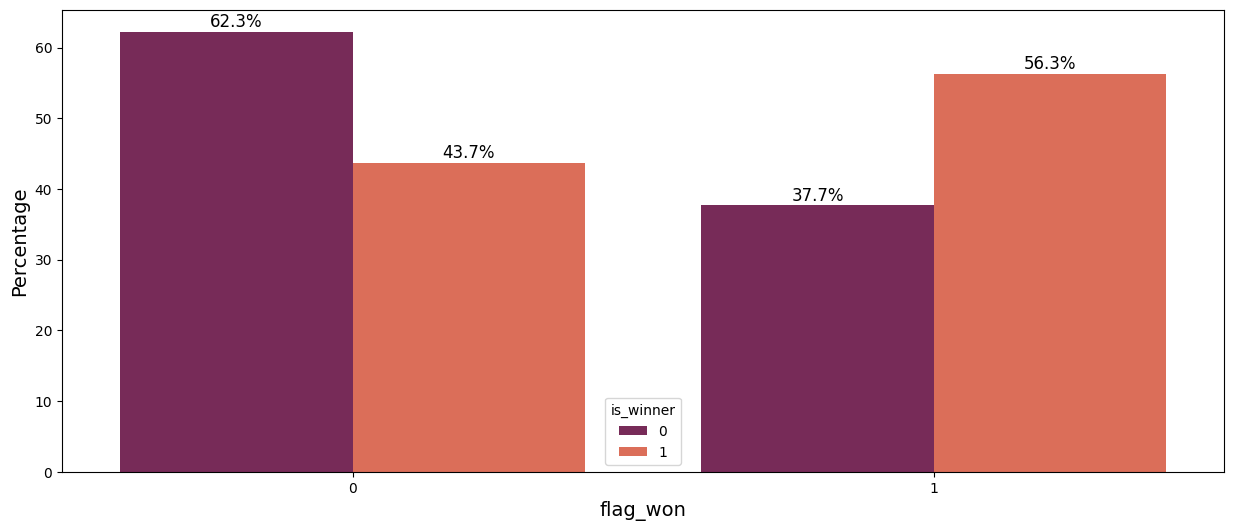

In [52]:
barplot_group(df_4, 'flag_won', 'is_winner')

Из графика хорошо видно, что процент победителей среди тех, кто уже побеждал в закупках с данным покупателем, значительно выше.

## Гипотеза 5

В закупках с большей ценой участвует больше поставщиков, из-за чего шансы победить в них для конкретного поставщика снижаются

In [62]:
df_5 = df.join(df.groupby('purchase').size().rename('n_part'), 
               on='purchase', 
               how='inner')[['price', 'n_part']]

In [63]:
df_5 = remove_outliers(df_5, 'price')

<Axes: xlabel='n_part', ylabel='price'>

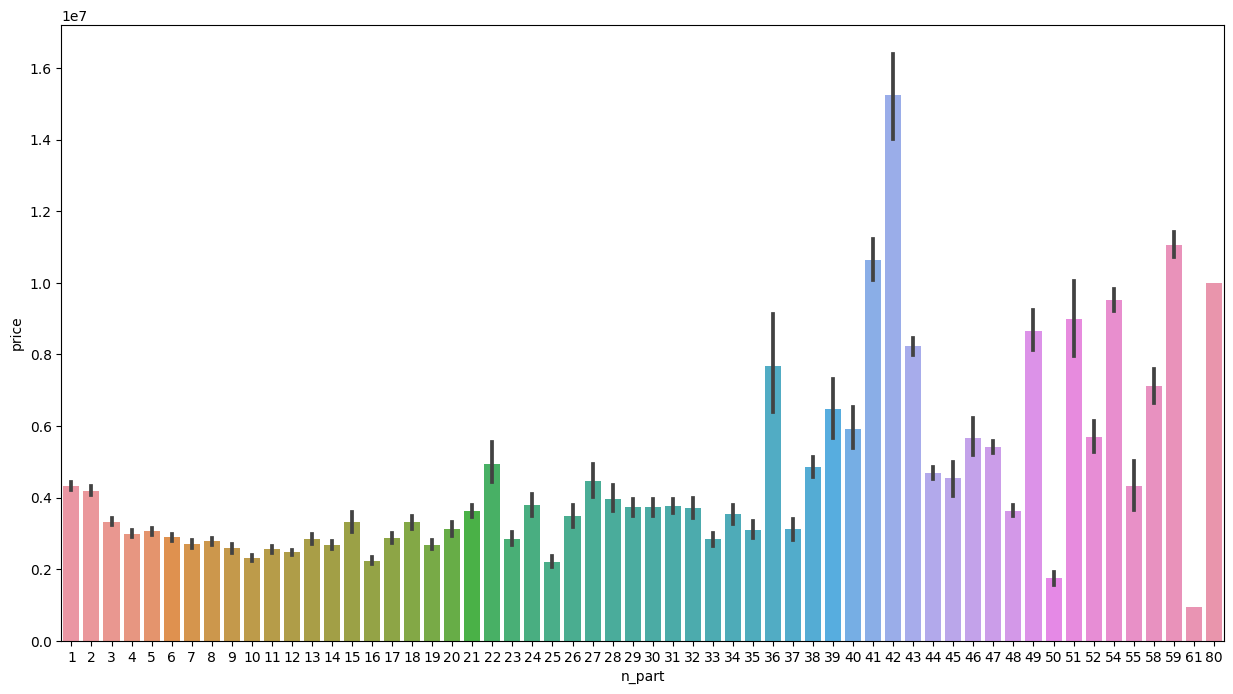

In [64]:
#средняя цена закупки в разрезе кол-ва участников в ней
fig = plt.figure(figsize=[15,8])
sns.barplot(x=df_5.n_part, y=df_5.price)

In [58]:
def weighted_moving_average(data, weights, n_window=5):
    """
    Вычисляет скользящее среднее.
    
    Аргументы:
    data -- список значений временного ряда
    weights -- список весов, соответствующих значениям в data
    n_window -- количество элементов для вычисления скользящего среднего

    Возвращает:
    moving_average -- список значений взвешенного скользящего среднего
    """
    moving_average = []
    for i in range(len(data)):
        if i < n_window:
            # Вычисляем взвешенное среднее для первых i элементов
            window = data[:i+1]
            weights_window = weights[:i+1]
        else:
            # Вычисляем взвешенное среднее для n_window элементов
            window = data[i-n_window+1:i+1]
            weights_window = weights[i-n_window+1:i+1]
        # Вычисляем взвешенное среднее
        moving_average.append(sum([a*b for a,b in zip(window, weights_window)]) / sum(weights_window))
    return moving_average


In [65]:
mov_avg = weighted_moving_average(df_5.groupby('n_part')['price'].mean(), 
                                  df_5.groupby('n_part').size() / df_5.shape[0],
                                  n_window=5)

<Axes: ylabel='price'>

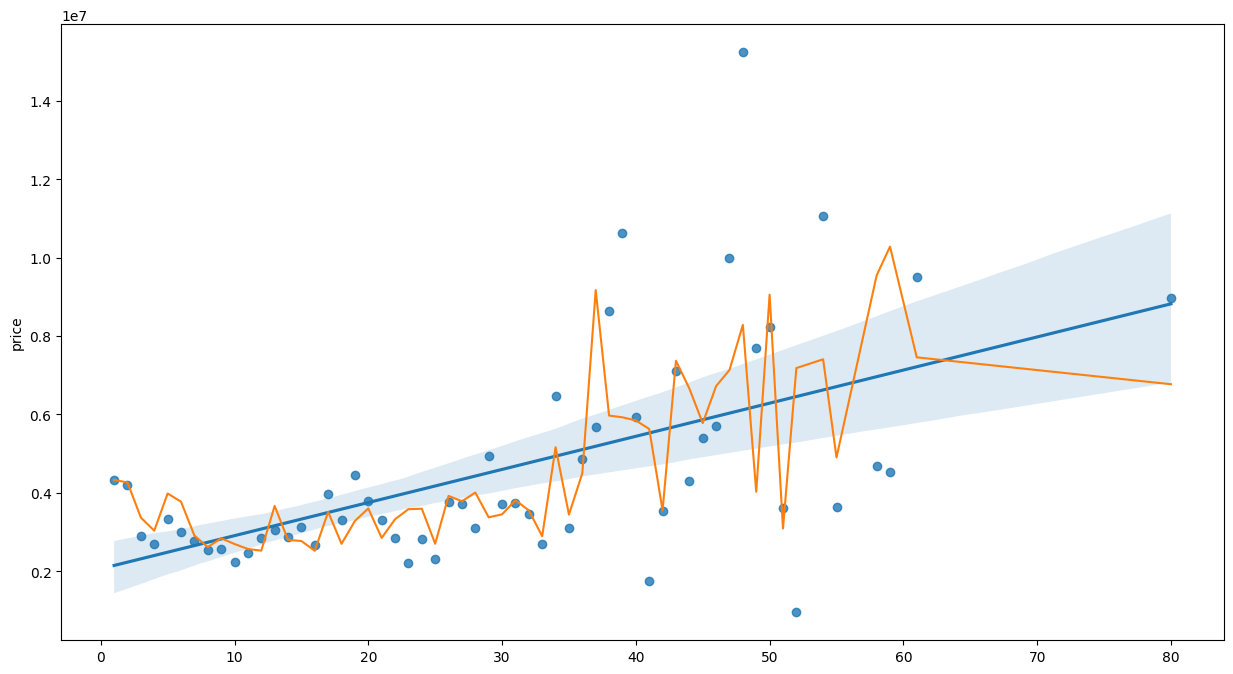

In [66]:
#построим линейную регрессию по средней цене от кол-ва участников с учетом доверительных интервалов
fig = plt.figure(figsize=[15,8])
sns.regplot(x=df_5.n_part.unique(), 
            y=df_5.groupby('n_part')['price'].mean(), ci=95, label='Лин. регрессия')
sns.lineplot(x=df_5.n_part.unique(), y=mov_avg, label='Скольз. среднее')

fig.legend()

По данным графикам можно подтвердить гипотезу, что в закупках с большей ценой участвует больше поставщиков. При этом побеждает всегда только один, из-за чего вероятность победы каждого поставщика в отдельности снижается.

## Гипотеза 6

Поставщики, у которых уже специализация по категориям okpd2, чаще побеждают в закупках.

In [68]:
df_6 = df.groupby('supplier')['okpd2_code'].nunique().to_frame(name='n_okpd2')

In [69]:
df_6['n_wins'] = df.groupby('supplier')['is_winner'].sum()
df_6['win_share'] = df_6['n_wins'] / df.groupby('supplier').size()
df_6['n_part'] = df.groupby('supplier').size()

In [70]:
df_6[:5]

,n_okpd2,n_wins,win_share,n_part
supplier,,,,
1,4,21,1.000000,21
10,1,3,0.428571,7
100,3,4,0.666667,6
1000,3,0,0.000000,3
10000,4,3,0.300000,10


In [72]:
df_6 = remove_outliers(df_6, 'n_part')

In [73]:
df_6.nunique()

n_okpd2        40
n_wins        106
win_share    1647
n_part        129
dtype: int64

<Axes: xlabel='n_okpd2', ylabel='n_wins'>

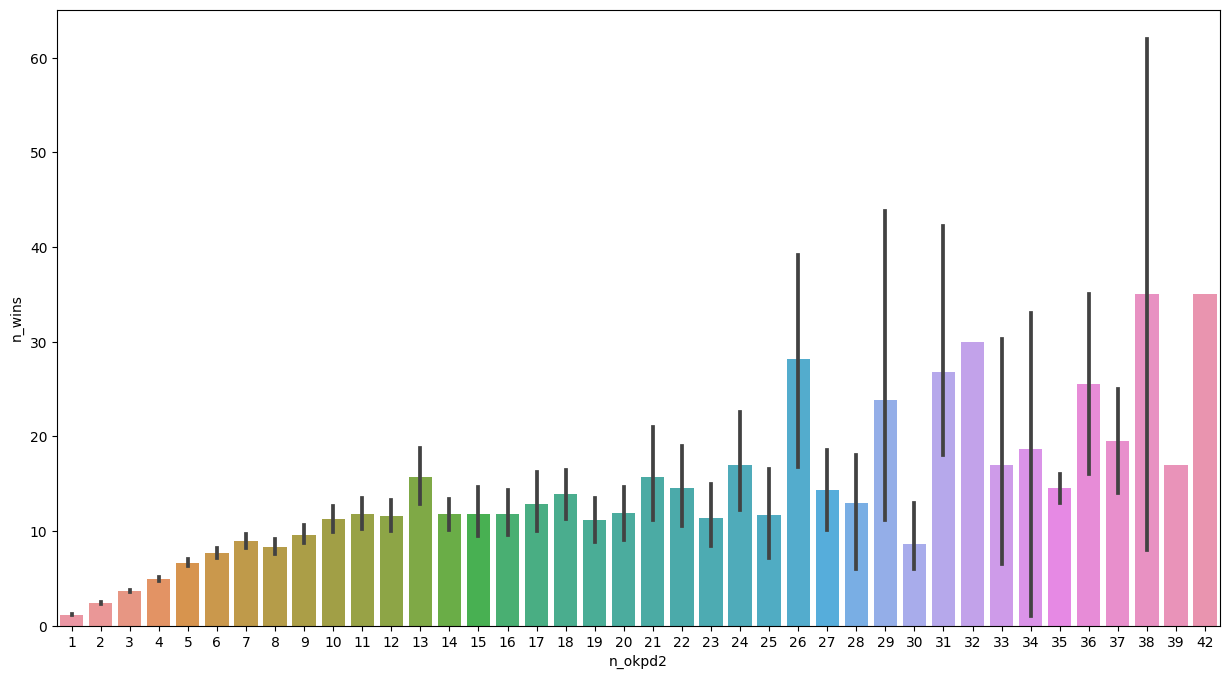

In [74]:
#средняя кол-во побед поставщиков в разрезе кол-ва униклальных категорий okpd2
fig = plt.figure(figsize=[15,8])
sns.barplot(x=df_6.n_okpd2, y=df_6.n_wins)

<Axes: xlabel='n_okpd2', ylabel='win_share'>

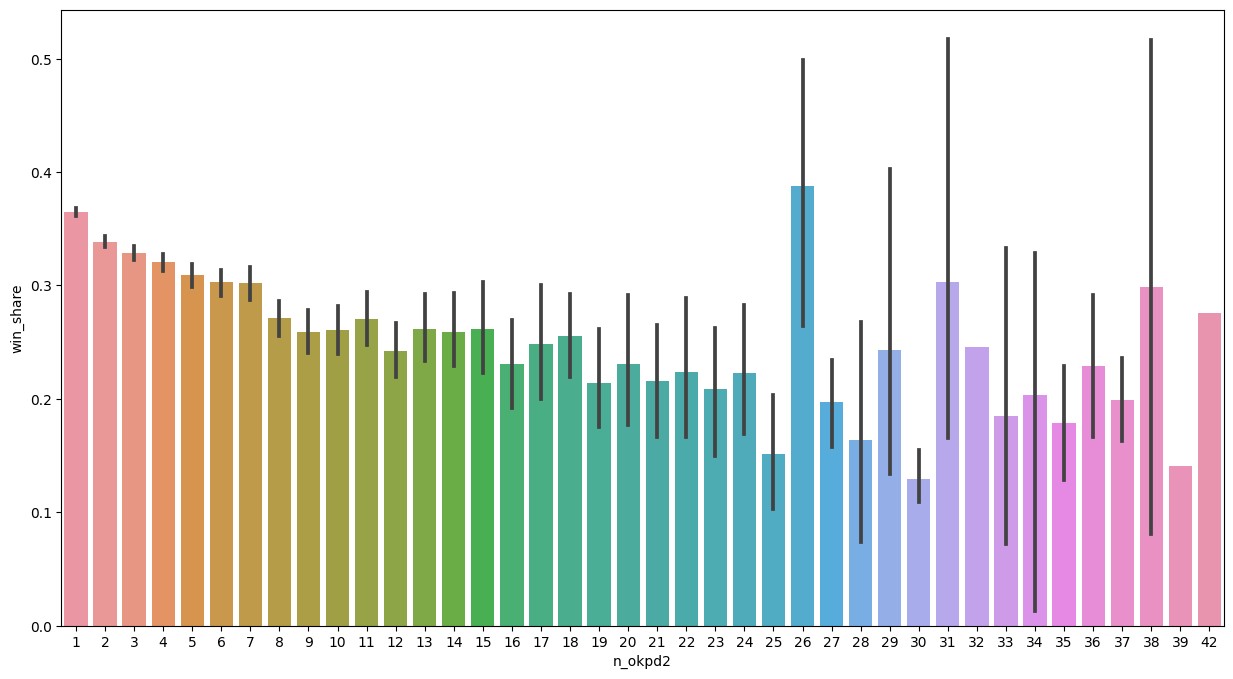

In [75]:
#средняя доля побед поставщиков в разрезе кол-ва униклальных категорий okpd2
fig = plt.figure(figsize=[15,8])
sns.barplot(x=df_6.n_okpd2, y=df_6.win_share)

In [224]:
mov_avg = weighted_moving_average(df_6.groupby('n_okpd2')['win_share'].mean(), 
                                  df_6.groupby('n_okpd2').size(), n_window=7)

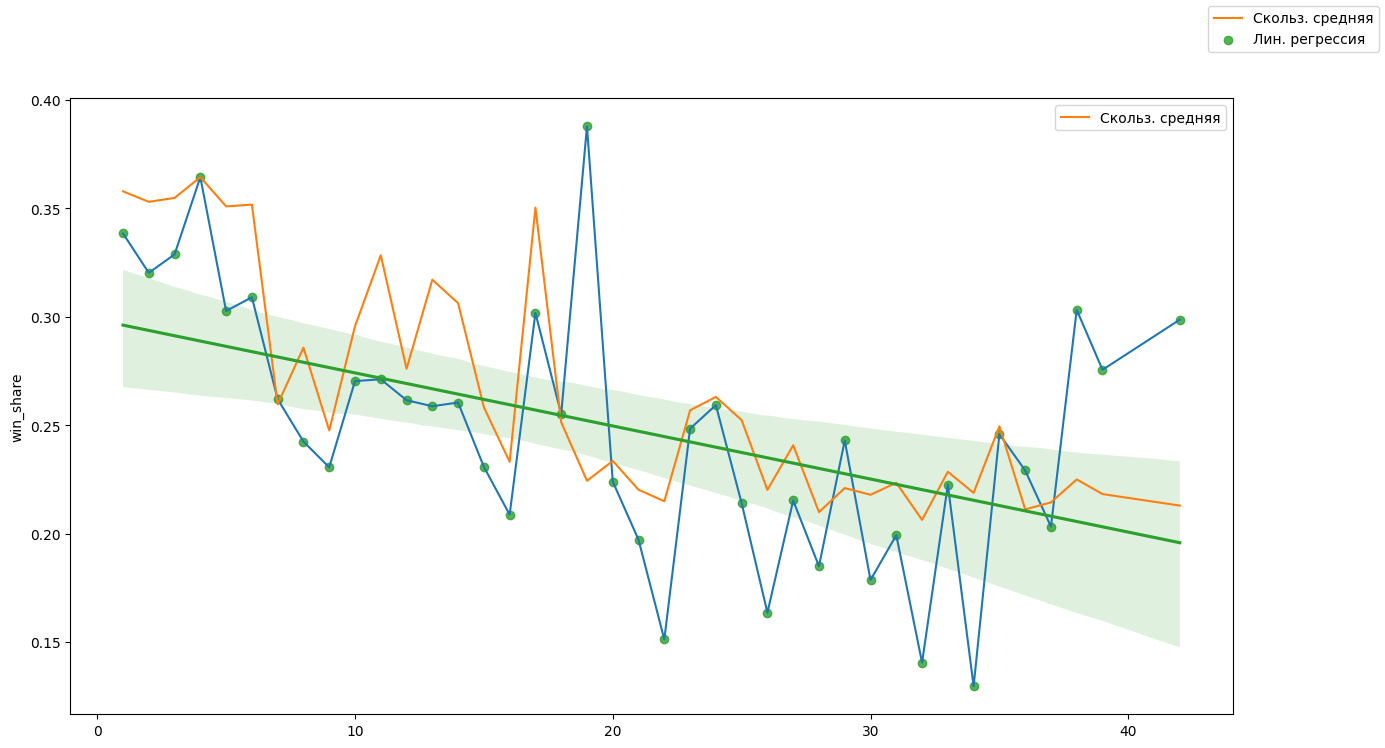

In [227]:
fig = plt.figure(figsize=[15,8])
sns.lineplot(x=df_6.n_okpd2.unique(), 
             y=df_6.groupby('n_okpd2')['win_share'].mean())
sns.lineplot(x=df_6.n_okpd2.unique(), y=mov_avg, label='Скольз. средняя')
sns.regplot(x=df_6.n_okpd2.unique(), 
            y=df_6.groupby('n_okpd2')['win_share'].mean(), label='Лин. регрессия')

fig.legend()

<Axes: xlabel='n_okpd2', ylabel='n_part'>

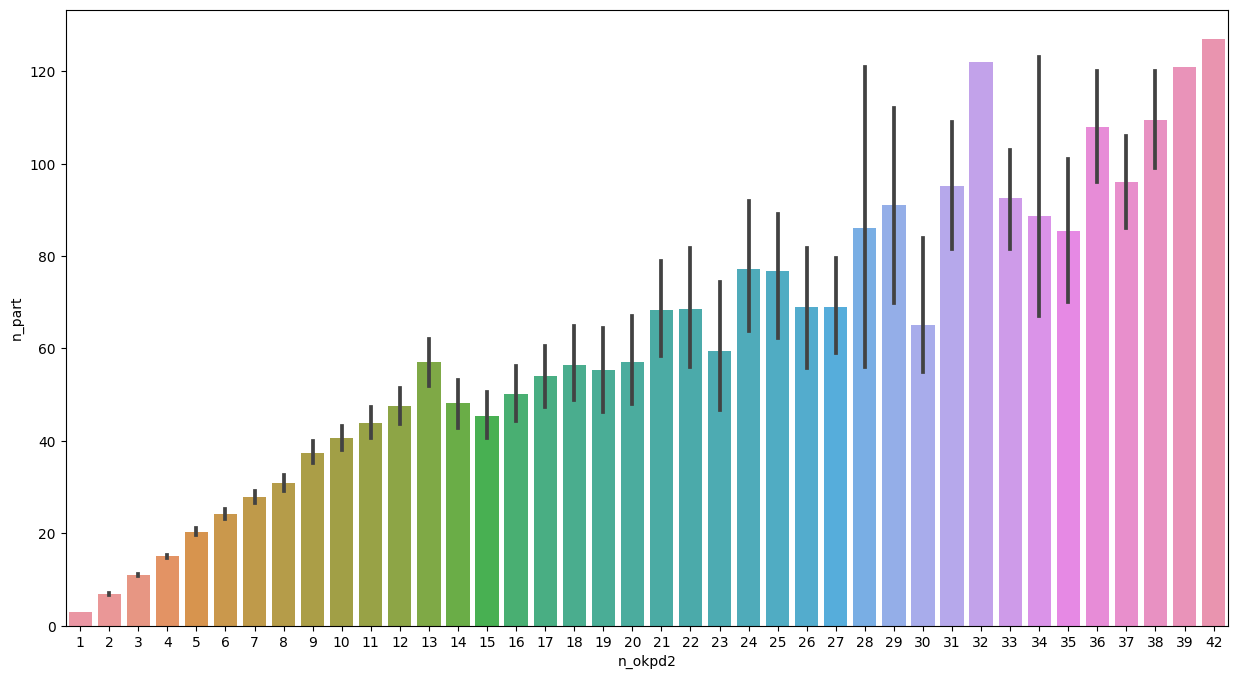

In [80]:
#среднее кол-во участий поставщиков в разрезе кол-ва уникальных категорий okpd2
fig = plt.figure(figsize=[15,8])
sns.barplot(x=df_6.n_okpd2, y=df_6.n_part)

In [81]:
mov_avg = weighted_moving_average(df_6.groupby('n_part')['win_share'].mean(), 
                                  df_6.groupby('n_part').size(), n_window=10)

<Axes: ylabel='win_share'>

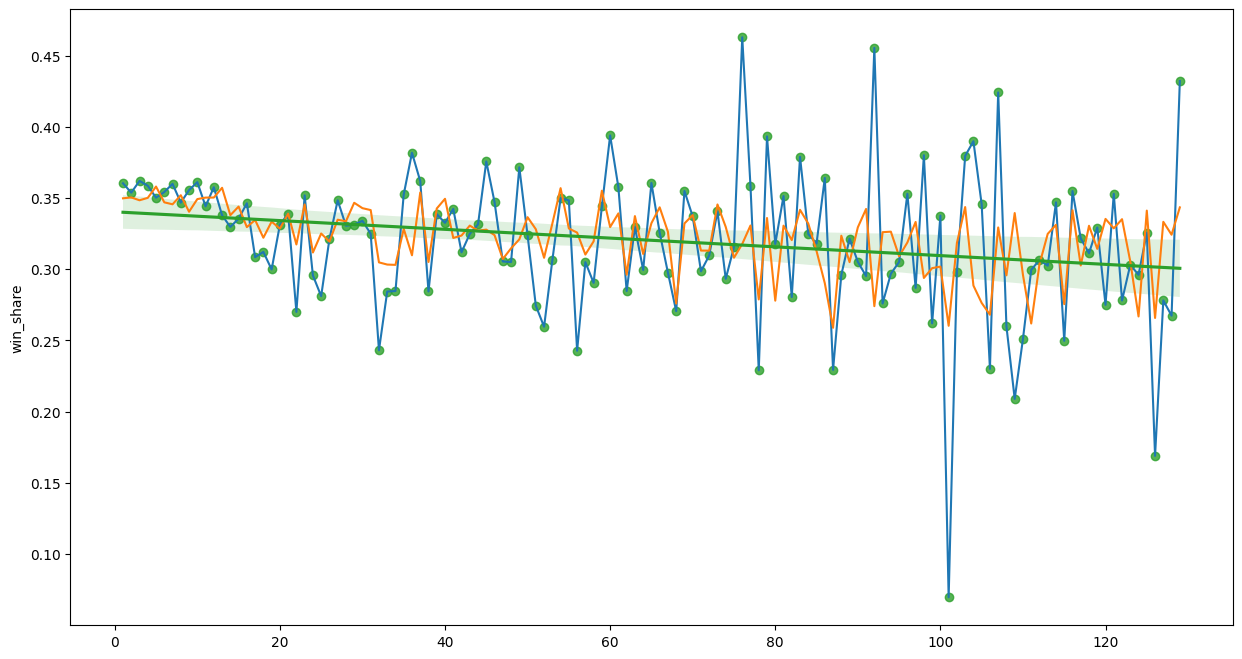

In [222]:
fig = plt.figure(figsize=[15,8])
sns.lineplot(x=df_6.n_part.unique(), 
             y=df_6.groupby('n_part')['win_share'].mean())
sns.lineplot(x=df_6.n_part.unique(), y=mov_avg, label='Скольз. среднее')
sns.regplot(x=df_6.n_part.unique(), 
            y=df_6.groupby('n_part')['win_share'].mean(), label='Лин. регрессия')

fig.legend()

Из данных графиков можно сделать несколько выводов. Во-первых, у поставщиков с большим количеством уникальных okpd2 больше побед в закупках. Однако это объясняется тем, что у поставщиков с большим количеством уникальных okpd2 больше участий в закупках. Во-вторых, у поставщиков с большим количеством уникальных okpd2 ниже процент побед в закупках. И вот это нельзя объяснить большим количеством участий, так как явной взаимосвязи между количеством участий и процентом побед нет.

## Гипотеза 7

В закупках, у которых нет ограничения на размер компании-участника, больше участников, из-за чего шансы победить в них для конкретного поставщика снижаются 

In [83]:
df_7 = df.groupby('purchase').size().to_frame('n_part')
df_7 = df_7.join(df.groupby('purchase')['forsmallbiz'].first().to_frame('forsmallbiz'))

In [84]:
df_7[:5]

,n_part,forsmallbiz
purchase,,
1,3,0
10,1,1
100,3,0
1000,6,1
10000,3,1


In [85]:
df_7 = remove_outliers(df_7, 'n_part')

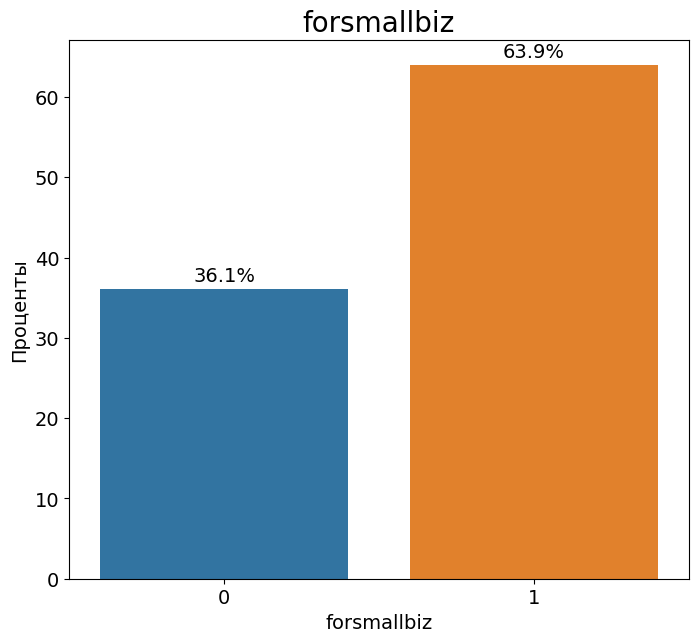

In [86]:
get_bins_target(df_7, 'forsmallbiz')

<Axes: xlabel='forsmallbiz', ylabel='n_part'>

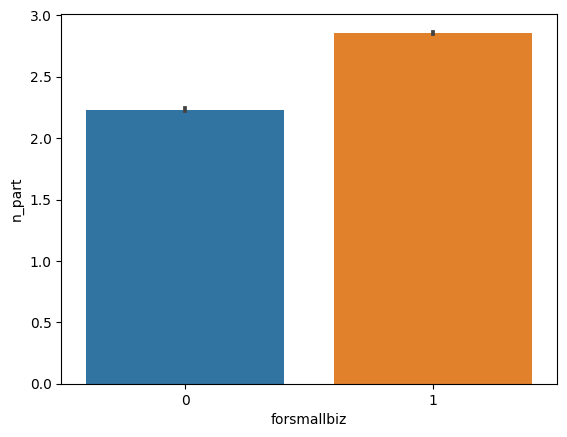

In [87]:
#среднее кол-во участников в закупке в разрезе ограничения на размер поставщика
sns.barplot(x=df_7.forsmallbiz, y=df_7.n_part)

Видно, что среднее значение кол-ва участников в закупках с ограничением на размер компании-поставщика выше. Однако воспользуемся статистическим критерием, чтобы оценить значимость этого различия. 

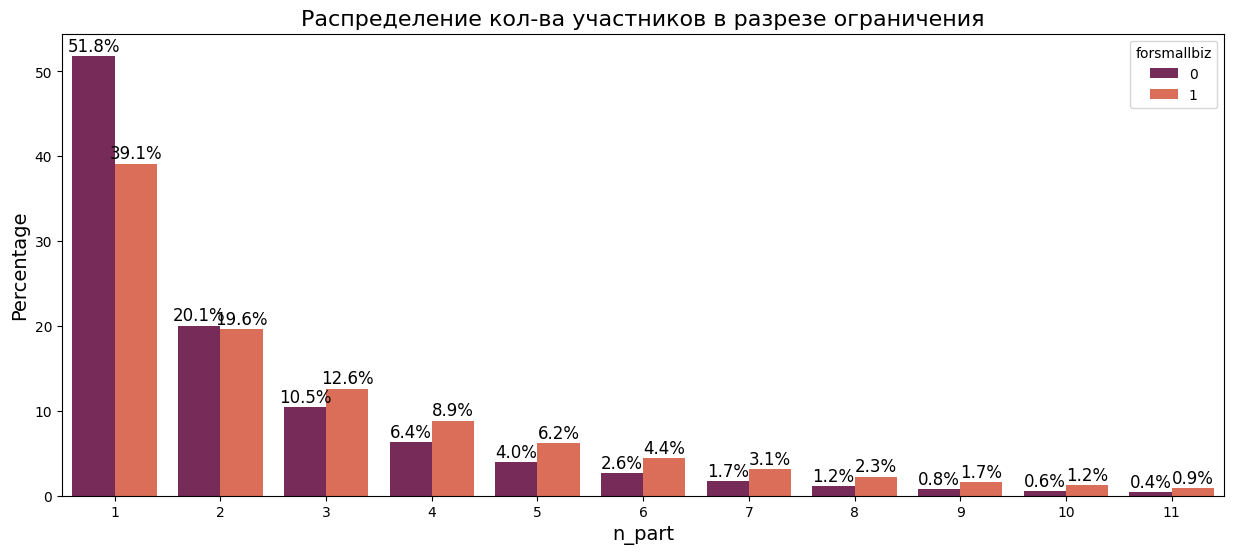

In [221]:
barplot_group(df_7, 'n_part', 'forsmallbiz', title='Распределение кол-ва участников в разрезе ограничения')

Распределение не является нормальным, поэтому применим ЦПТ для последующего использования t-теста Стьюдента

  0%|          | 0/2000 [00:00<?, ?it/s]

<Axes: ylabel='Density'>

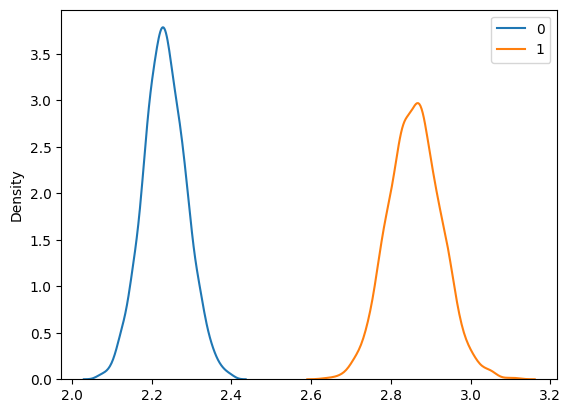

In [90]:
means_formallbiz_0_cpt = []
means_formallbiz_1_cpt = []

for i in tqdm(range(2000)):
    sample_n = df_7[df_7['forsmallbiz'] == 0].n_part.sample(1200)
    means_formallbiz_0_cpt.append(np.mean(sample_n))
    
    sample_o = df_7[df_7['forsmallbiz'] == 1].n_part.sample(1200)
    means_formallbiz_1_cpt.append(np.mean(sample_o))
    
sns.kdeplot(data=(means_formallbiz_0_cpt, means_formallbiz_1_cpt))

In [91]:
def check_norm(sample: list) -> None:
    """
    Проверка выборки на нормальность критерием Шапиро-Уилка
    """
    p_value = stats.shapiro(sample).pvalue
    
    if p_value > 0.05:
        print(f"Нормальное распределение\n{round(p_value, 3)}")
    else:
        print(f"Ненормальное распределение\n{round(p_value, 3)}")
        
check_norm(means_formallbiz_0_cpt)
check_norm(means_formallbiz_1_cpt)

Нормальное распределение
0.439
Нормальное распределение
0.101


Из графика выборочных средних без применения t-теста Стьюдента очевидно, что различия значимы.

Гипотеза не подтвердилась, но из графиков можно сделать другой вывод. В закупках с ограничением по размеру компании-поставщика в среднем больше участников, чем в закупках без ограничения.

## Гипотеза 8

Сезонность влияет на участие поставщиков в закупках, поэтому это нужно учитывать при рекомендациях

In [133]:
df_temp = df[['min_publish_date', 'purchase', 'okpd2_code']]
df_temp['month'] = df_temp['min_publish_date'].dt.month

df_8 = df_temp.groupby('month').size().to_frame('n_part')
df_8['n_purc'] = df_temp.groupby('month')['purchase'].nunique()
df_8['avg_part'] = df_8['n_part'] / df_8['n_purc']

/tmp/ipykernel_93685/46847297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['month'] = df_temp['min_publish_date'].dt.month


<Axes: xlabel='month', ylabel='n_part'>

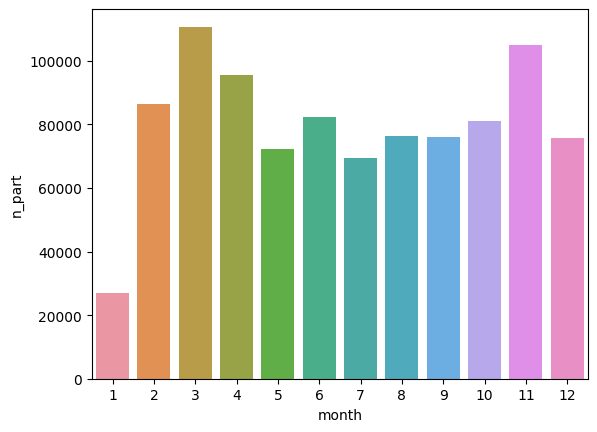

In [124]:
#кол-во участников в разрезе месяца даты публикации закупки
sns.barplot(x=df_8.index, y=df_8['n_part'])

<Axes: xlabel='month', ylabel='avg_part'>

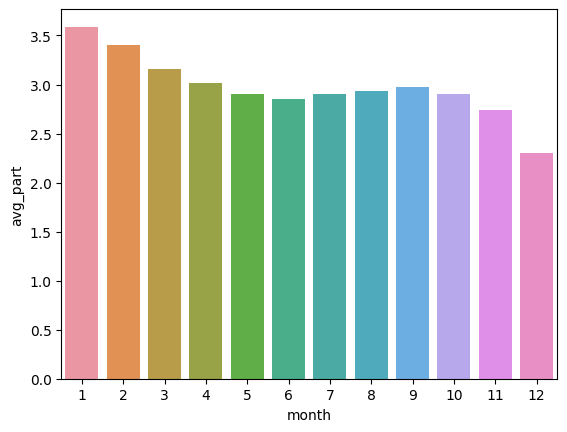

In [125]:
#среднее значение участников закупки в разрезе месяца даты публикации
sns.barplot(x=df_8.index, y=df_8['avg_part'])

По имеющимся данным можно сделать вывод, что самыми активными с точки зрения участий поставщиков месяцами являются март и ноябрь. При этом средним значением кол-ва участников в закупке эти месяца не выделяются. В декабре же наименьшее среднее значение участий поставщиков в закупке

## Гипотеза 9

Сезонность влияет на количество закупок на рынке в целом, отчего изменяется степень участия поставщиков в них.

In [128]:
df_temp.groupby('month')['purchase'].nunique()

month
1      7535
2     25478
3     35115
4     31691
5     24971
6     28840
7     23929
8     26039
9     25529
10    27996
11    38248
12    32886
Name: purchase, dtype: int64

In [130]:
df_temp['month'].unique()

array([ 2,  3, 11, 12,  1,  9, 10,  4,  6,  8,  7,  5])

<Axes: ylabel='purchase'>

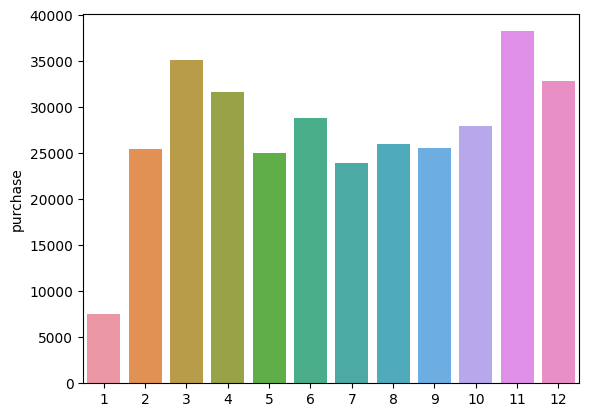

In [132]:
#количество закупок на рынке в разрезе месяца даты публикации
sns.barplot(x=df_temp['month'].sort_values().unique(),
            y=df_temp.groupby('month')['purchase'].nunique())

По кол-ву закупок самыми активными месяцами стали март и ноябрь. При этом также число в 300 тысяч закупок превысили декабрь и апрель. Большое кол-во закупок в декабре может объяснить низкое значение среднего числа поставщиков-участников на одну закупку в этом месяце.

## Гипотеза 10

Значительная часть категорий закупок в силу сезонности находится на рынке только определенные месяцы, что важно для корректной работы рекомендательной системы

In [181]:
df_10 = df_temp.groupby(['okpd2_code', 'month']).size().reset_index(name='number')
df_10 = df_10.set_index('month')

okpd2_mean = df_10.groupby('okpd2_code')['number'].mean()
okpd2_coef = {} #cловарь, содержащий коэффициенты сезонности для каждого okpd2_code

for okpd2 in df_10['okpd2_code'].unique():
    okpd2_coef[okpd2] = (df_10[df_10['okpd2_code'] == okpd2]['number'] 
                         / okpd2_mean.loc[okpd2]).to_frame(okpd2).T

In [186]:
#матрица с коэффициентами сезонности 
df_10 = pd.concat(okpd2_coef).droplevel(0)

In [214]:
df_10[:5]

month,1,2,3,4,5,6,7,8,9,10,11,12
01.1,0.151772,0.643035,0.964553,0.922616,0.966550,1.457813,0.784823,1.256116,0.866700,0.796805,1.799301,1.389915
01.2,0.168456,0.703551,0.862097,0.673823,1.208918,0.822461,0.520231,1.213873,0.867052,0.926507,2.526837,1.506193
01.3,0.088235,2.411765,3.441176,1.823529,0.970588,1.147059,0.588235,0.823529,0.411765,0.117647,0.029412,0.147059
01.4,0.112601,0.699732,0.546917,0.941019,1.471850,1.262735,0.844504,0.989276,0.691689,0.514745,2.404826,1.520107
01.6,0.116505,0.815534,4.660194,3.378641,0.699029,0.233010,1.165049,0.000000,0.116505,0.000000,0.349515,0.466019


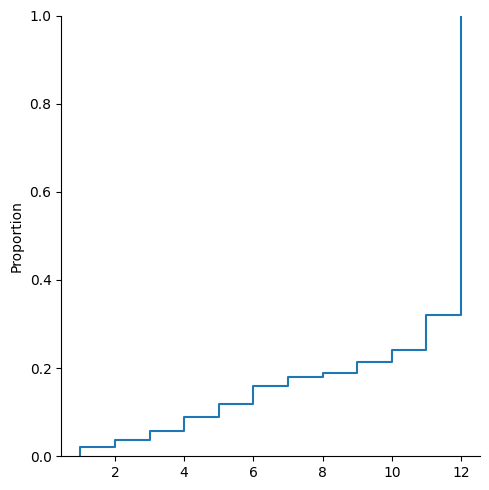

In [219]:
#Кумулятивная функция распределения количества ненулевых значений матрицы коэф. сез.
sns.displot(df_10.apply(lambda x: (x != 0).sum(), axis=1), kind='ecdf')

Из графика выше видно, что практически 40% категорий имеют хотя бы 1 месяц, когда соответствующих закупок нет на рынке, что указывает на выраженную взаимосвязь между сезонностью и категориями закупок на рынке

# Feature engineering

In [28]:
nlp = spacy.load("ru_core_news_sm")

def lemmatize_text(text: str):
    # Создаем объект Doc для строки, который проходит через обработчики языка
    doc = nlp(text)

    return {_.lemma_ for _ in doc if _.pos_ in {'ADJ', 'NOUN', 'PROPN'}}

def lemmatize_texts(texts):
    with Pool(processes=cpu_count()-1) as pool:
        lemmatized_texts = pool.map(lemmatize_text, texts)
    return lemmatized_texts

In [45]:
def lemmatize_text(text: str):
    # Создаем объект Doc для строки, который проходит через обработчики языка
    doc = nlp(text)

    return {_.lemma_ for _ in doc if _.pos_ in {'ADJ', 'NOUN', 'PROPN'}}

def process_row(row):
    set1, set2, set3 = row['purchase_name'], row['okpd2_names'], row['item_descriptions']
    token_set = frozenset(lemmatize_text(set1)).union(frozenset(lemmatize_text(set2)), 
                                                      frozenset(lemmatize_text(set3)))
    return token_set

def get_tokens(df: pd.DataFrame):
    with Pool() as pool:
        tokens_list = pool.map(process_row, df.to_dict('records'))
        
    return pd.Series(tokens_list)

In [47]:
df['tokens'] = get_tokens(df)

In [49]:
df[:5]

,purchase,region_code,min_publish_date,forsmallbiz,price,customer,okpd2_code,supplier,is_winner,reg_code_small,tokens
8,3,2,2021-02-02,1,290000.00,2,58.2,1,1,58.2_2_1,"(год, заказчик, оказание, муниципальный, консу..."
8151,2834,2,2021-02-02,1,105000.00,218,62.0,1,1,62.0_2_1,"(замена, подобный, ш., объект, парковый, право..."
457484,154949,2,2021-02-16,1,98967.50,11235,63.9,1,1,63.9_2_1,"(сточный, вода, рассказово, прокладка, сеть, м..."
437783,147950,2,2021-03-10,0,77460.03,11061,62.0,1,1,62.0_2_0,"(год, центр, поставка, вентиляция, искусственн..."
488119,165990,2,2021-03-26,0,138000.00,11558,62.0,1,1,62.0_2_0,"(замена, стартер, резьбовой, оказание, исполни..."


In [48]:
df = df.drop(columns=['purchase_name', 'okpd2_names', 'item_descriptions'])

In [60]:
df['reg_code_small'] = df['okpd2_code'].astype('str') + '_' \
                + df['region_code'].astype('str') + '_' \
                + df['forsmallbiz'].astype('str')

df['reg_code_small'] = df['reg_code_small'].astype('category')

In [51]:
df['month'] = df['min_publish_date'].dt.month

In [56]:
#флаг, что поставщик уже работал с этим заказчиком
df['flag_won'] = df.groupby(['supplier', 'customer'])['is_winner'] \
                   .cumcount() \
                   .apply(lambda x: 1 if x != 0 else 0)

In [6]:
df = df.drop(columns=['region_code', 'forsmallbiz', 'okpd2_code'])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958129 entries, 8 to 757195
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   purchase          958129 non-null  category      
 1   region_code       958129 non-null  category      
 2   min_publish_date  958129 non-null  datetime64[ns]
 3   forsmallbiz       958129 non-null  int64         
 4   price             958129 non-null  float64       
 5   customer          958129 non-null  category      
 6   okpd2_code        958129 non-null  category      
 7   supplier          958129 non-null  category      
 8   is_winner         958129 non-null  int64         
 9   reg_code_small    958129 non-null  category      
 10  tokens            958129 non-null  object        
 11  month             958129 non-null  int64         
 12  flag_won          958129 non-null  int64         
dtypes: category(6), datetime64[ns](1), float64(1), int64(4), ob

In [8]:
df.to_csv('eda.csv')